In [1]:
import os
gpu_number = "2"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_number

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from src.data_loader.classification import ClassifyDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

task = "classification"
data_set_name = "detect_lvi"
batch_size = 32
on_memory = True
argumentation_proba = 0.8
target_size = (512,512)
interpolation = "bilinear"
class_mode = "binary"
# class_mode = "categorical"
dtype="float32"

train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/train/*/*")
valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/*/*")
test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/test/*/*")
label_list = os.listdir(f"./datasets/{task}/{data_set_name}/train")

label_to_index_dict = {label:index for index, label in enumerate(label_list)}
index_to_label_dict = {index:label for index, label in enumerate(label_list)}

train_data_loader = ClassifyDataloader(image_path_list=train_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=argumentation_proba,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,
                                       shuffle=True,
                                       class_mode=class_mode,
                                       dtype=dtype
)
valid_data_loader = ClassifyDataloader(image_path_list=valid_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       on_memory=on_memory,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       class_mode=class_mode,
                                       dtype=dtype
)
test_data_loader = ClassifyDataloader(image_path_list=test_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=1,
                                       on_memory=False,
                                       argumentation_proba=0,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       class_mode=class_mode,
                                       dtype=dtype
)

 [8608/8608] |##############################################| (Time:  0:05:10) 
 [04/1609] |                                                | (ETA:   0:00:40) 

Total data num 8608 with 2 classes


 [1609/1609] |##############################################| (Time:  0:00:59) 


Total data num 1609 with 2 classes
Total data num 1469 with 2 classes


In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

import numpy as np
np.random.seed(1337)  # for reproducibility

DROPOUT_RATIO = 0.5

grad_cam = False
transfer_learning = False
transfer_train_mode = "include_deep_layer"
layer_name_frozen_to = "mixed4"

#  binary_sigmoid, categorical_sigmoid, categorical_softmax
activation = "binary_sigmoid"

# create the base pre-trained model~
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    pooling=None,
    classifier_activation=None
)

if transfer_learning:
    if train_mode == "dense_only":
        base_model.trainable = False
    elif train_mode == "include_deep_layer":
        for layer in base_model.layers: 
            layer.trainable = False
            if layer.name == layer_name_frozen_to:
                break

# add a global spatial average pooling layer
x = base_model.output
# (Batch_Size,?)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATIO)(x)
# let's add a fully-connected layer
# (Batch_Size,1)
x = Dense(1024, activation='relu')(x)
# (Batch_Size,1024)
x = Dropout(DROPOUT_RATIO)(x)

if grad_cam:
    x *= 1e-1
    keras_backend.set_floatx('float64')
    dense_dtype = "float64"
else:
    dense_dtype = "float32"
    
if activation == "binary_sigmoid":
    predictions = Dense(1, activation='sigmoid', dtype=dense_dtype)(x)
    loss_function = BinaryCrossentropy(label_smoothing=0.01)
elif activation == "categorical_sigmoid":
    predictions = Dense(len(label_list), activation='sigmoid', dtype=dense_dtype)(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)
elif activation == "categorical_softmax":
    predictions = Dense(len(label_list), activation='softmax', dtype=dense_dtype)(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)

# this is the model we will train
model = Model(base_model.input, predictions)

In [4]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

class ClassificationMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, data_loader, save_image_path, index_to_label_dict, num_img=4):
        self.data_loader = data_loader
        self.num_img = num_img
        self.save_image_path = save_image_path
        os.makedirs(save_image_path, exist_ok=True)
        
    def on_epoch_end(self, epoch, logs=None):
        
        len_data_loader = len(self.data_loader)
        random_index = range(len_data_loader)
        random_index = np.random.permutation(random_index)[:self.num_img]
        
        _, ax = plt.subplots(self.num_img // 2, 2, figsize=(12, 12))
        for current_index, image_index in enumerate(random_index):
            image_array, label = self.data_loader.data_getter[image_index].values()
            iamge_array_name = self.data_loader.data_getter.image_path_dict[image_index]
            
            image_array = np.expand_dims(image_array, axis=0)
            label = np.expand_dims(label, axis=0)
            
            prediction = self.model(image_array).numpy()[0]
            prediction = np.round(prediction, dtype="int32")
            
            image_array = (image_array[0] * 127.5 + 127.5).astype(np.uint8)
            target_image_array = (target_image_array[0] * 127.5 + 127.5).astype(np.uint8)
            
            ax[current_index, 0].imshow(image_array)
            ax[current_index, 1].imshow(prediction)
            ax[current_index, 0].set_title("Input image_x")
            ax[current_index, 1].set_title("Translated image_y")

            ax[current_index, 2].imshow(target_image_array)
            ax[current_index, 3].imshow(reverse_prediction)
            ax[current_index, 2].set_title("Input image_y")
            ax[current_index, 3].set_title("Translated image_x")

            prediction = image.array_to_img(prediction)
            reverse_prediction = image.array_to_img(reverse_prediction)
        plt.savefig(f"{self.save_image_path}/generated_image_{epoch+1}")
        plt.show()
        plt.close()

In [5]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./result_daily/{task}/{data_set_name}/{today_str}/{gpu_number}/target_size_{target_size}/weights/" 
today_image_path = f"./result_daily/{task}/{data_set_name}/{today_str}/{gpu_number}/target_size_{target_size}/images/"
today_logs_path = f"./result_daily/{task}/{data_set_name}/{today_str}/{gpu_number}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-4, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)

csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [ ]:
start_epoch = 0
epochs = 200

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 1/200
269/269 [==============================] - 286s 983ms/step - loss: 0.3695 - accuracy: 0.8303 - val_loss: 0.3826 - val_accuracy: 0.8788
Epoch 2/200
269/269 [==============================] - 263s 977ms/step - loss: 0.1876 - accuracy: 0.9385 - val_loss: 0.3666 - val_accuracy: 0.8850
Epoch 3/200
269/269 [==============================] - 265s 982ms/step - loss: 0.1337 - accuracy: 0.9629 - val_loss: 0.4340 - val_accuracy: 0.8756
Epoch 4/200
269/269 [==============================] - 264s 979ms/step - loss: 0.1074 - accuracy: 0.9708 - val_loss: 0.4151 - val_accuracy: 0.8850
Epoch 5/200
269/269 [==============================] - 265s 982ms/step - loss: 0.0944 - accuracy: 0.9777 - val_loss: 0.3407 - val_accuracy: 0.8869
Epoch 6/200
269/269 [==============================] - 265s 981ms/step - loss: 0.0878 - accuracy: 0.9794 - val_loss: 0.3826 - val_accuracy: 0.8744
Epoch 7/200
269/269 [==============================] - 265s 983ms/step - loss: 0.0775 - accuracy: 0.9837 - val_loss: 0

# Learning Curve

['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']
val_loss_min (epoch, loss, accuracy): (16, 0.0045, 0.9590)
val_dice_score_max (epoch, loss, accuracy): (16, 0.0045, 0.9590)
loss_score_diff_min (epoch, loss, accuracy): (16, 0.0045, 0.9590)


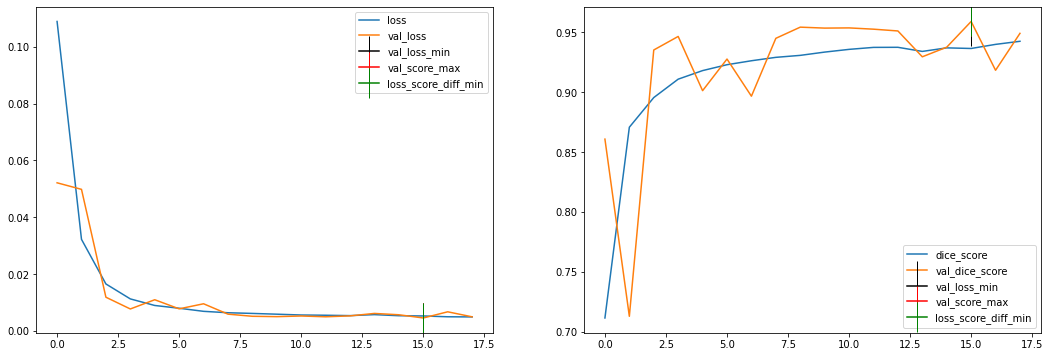

In [6]:
import csv
import shutil
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

result_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_None/iter_{mask_iter}/"
result_weights = glob(f'{result_path}/weights/*')

with open(f'{result_path}/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

loss_min_epoch = np.argmin(dict_from_csv['val_loss']) + 1
loss_min_loss = np.min(dict_from_csv['val_loss'])
loss_min_accuracy = dict_from_csv['val_dice_score'][loss_min_epoch - 1]

score_max_epoch = np.argmax(dict_from_csv['val_dice_score']) + 1
score_max_loss = dict_from_csv['val_loss'][score_max_epoch - 1]
score_max_accuracy = np.max(dict_from_csv['val_dice_score'])

val_score = dict_from_csv['val_dice_score']
score_diff = np.maximum(np.array(dict_from_csv['dice_score'] - np.array(dict_from_csv['val_dice_score'])), 0)

loss_score_diff_min_epoch = np.argmax(val_score - score_diff) + 1
loss_score_diff_min_loss = dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1]
loss_score_diff_min_accuracy = dict_from_csv['val_dice_score'][loss_score_diff_min_epoch - 1]

print(f"val_loss_min (epoch, loss, accuracy): ({loss_min_epoch}, {loss_min_loss:.4f}, {loss_min_accuracy:.4f})")
print(f"val_dice_score_max (epoch, loss, accuracy): ({score_max_epoch}, {score_max_loss:.4f}, {score_max_accuracy:.4f})")
print(f"loss_score_diff_min (epoch, loss, accuracy): ({loss_score_diff_min_epoch}, {loss_score_diff_min_loss:.4f}, {loss_score_diff_min_accuracy:.4f})")

_, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(dict_from_csv["loss"])
ax[0].plot(dict_from_csv["val_loss"])
ax[0].plot(loss_min_epoch - 1, loss_min_loss, marker="|", color="black", markersize=30)
ax[0].plot(score_max_epoch - 1, dict_from_csv['val_loss'][score_max_epoch - 1], marker="|", color="red", markersize=30)
ax[0].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[0].legend(["loss", "val_loss", "val_loss_min", "val_score_max", "loss_score_diff_min"])

ax[1].plot(dict_from_csv["dice_score"])
ax[1].plot(dict_from_csv["val_dice_score"])
ax[1].plot(loss_min_epoch - 1, dict_from_csv['val_dice_score'][loss_min_epoch - 1], marker="|", color="black", markersize=50)
ax[1].plot(score_max_epoch - 1, score_max_accuracy, marker="|", color="red", markersize=30)
ax[1].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_dice_score'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[1].legend(["dice_score", "val_dice_score", "val_loss_min", "val_score_max", "loss_score_diff_min"])

plt.savefig(f"{result_path}/learning curve.png", dpi=300)
plt.show()
plt.close()


In [7]:
best_loss_path = glob(f"{result_path}/weights/weights_{loss_min_loss:.4f}_*.hdf5")[0]
shutil.copy(best_loss_path, f"{result_path}/epoch_{loss_min_epoch}_loss_{loss_min_loss:.4f}_dice_{loss_min_accuracy:.4f}.hdf5")
print(best_loss_path)

model.load_weights(best_loss_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/ihc_auto_curation_level_1/2021-08-03/gpu_0/target_size_None/iter_6//weights/weights_0.0045_0.0052_16.hdf5
1247/1247 [==============================] - 133s 96ms/step - loss: 0.0048 - dice_score: 0.9517


[0.004849335644394159, 0.9516533017158508]

In [8]:
best_score_path = glob(f"{result_path}/weights/*_{score_max_epoch:02d}.hdf5")[0]
shutil.copy(best_score_path, f"{result_path}/epoch_{score_max_epoch}_loss_{score_max_loss:.4f}_dice_{score_max_accuracy:.4f}.hdf5")
print(best_score_path)

model.load_weights(best_score_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/ihc_auto_curation_level_1/2021-08-03/gpu_0/target_size_None/iter_6//weights/weights_0.0045_0.0052_16.hdf5
1247/1247 [==============================] - 117s 94ms/step - loss: 0.0048 - dice_score: 0.9517


[0.004849335644394159, 0.9516533017158508]

In [9]:
best_diff_path = glob(f"{result_path}/weights/*_{loss_score_diff_min_epoch:02d}.hdf5")[0]
shutil.copy(best_diff_path, f"{result_path}/epoch_{loss_score_diff_min_epoch}_loss_{loss_score_diff_min_loss:.4f}_dice_{loss_score_diff_min_accuracy:.4f}.hdf5")
print(best_diff_path)

model.load_weights(best_diff_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/ihc_auto_curation_level_1/2021-08-03/gpu_0/target_size_None/iter_6//weights/weights_0.0045_0.0052_16.hdf5
1247/1247 [==============================] - 115s 92ms/step - loss: 0.0048 - dice_score: 0.9517


[0.004849335644394159, 0.9516533017158508]

# Inference

In [ ]:
best_diff_path = glob(f"{result_path}/weights/*_{loss_score_diff_min_epoch:02d}.hdf5")[0]
model.load_weights(best_diff_path)

thresh_hold = 0.8

negative_group_1 = np.where(model_predicted < thresh_hold)[0]
negative_group_2 = np.where(model_predicted != 0)[0]
negative_confirm = np.where(model_predicted == 0)[0]
negative_not_confirm = np.intersect1d(negative_group_1, negative_group_2)

positive_group_1 = np.where(model_predicted > thresh_hold)[0]
positive_group_2 = np.where(model_predicted != 1)[0]
postive_confirm = np.where(model_predicted == 1)[0]
postive_not_confirm = np.intersect1d(positive_group_1, positive_group_2)

ground_truth_negative = np.where(ground_truth == 0)[0]
ground_truth_positive = np.where(ground_truth == 1)[0]

true_negative = np.intersect1d(negative_group_1, ground_truth_negative)
true_positive = np.intersect1d(positive_group_1, ground_truth_positive)
false_negative = np.intersect1d(negative_group_1, ground_truth_positive)
false_positive = np.intersect1d(positive_group_1, ground_truth_negative)

print(len(negative_confirm))
print(len(negative_not_confirm))
print(len(postive_confirm))
print(len(postive_not_confirm))

print(len(negative_confirm))
print(len(negative_not_confirm))
print(len(postive_confirm))
print(len(postive_not_confirm))

print(false_negative)
print(false_positive)

In [ ]:
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

test_labels = ['ebv_neg','ebv_pos']
preds = np.argmax(model_predicted,axis=-1)

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()  